# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [1]:
from chxanalys.chx_libs import (np, roi, time, datetime, os,  
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model)

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average,plot_saxs_g4,
                get_angular_mask, get_ring_anglar_mask,save_seg_saxs_g2,plot_saxs_rad_ang_g2,
                 fit_saxs_rad_ang_g2,               
                                
                                )

from chxanalys.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                get_four_time_from_two_time,rotate_g12q_to_rectangle)

from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_t_iqc,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc)

from chxanalys.SAXS import fit_form_factor
from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
from chxanalys.chx_correlationp import (cal_g2p, auto_two_Arrayp)
from chxanalys.Create_Report import create_pdf_report

%matplotlib notebook

/opt/conda_envs/analysis/lib/python3.5/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "
/opt/conda_envs/analysis/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:

plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
#%reset

In [10]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [11]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /yuzhang/August/XPCS_SAXS_Flow_Sep.ipynb


## Make a directory for saving results

In [12]:
CYCLE = '2016_2'
username = getpass.getuser()
#username = "kyager"  #provide the username to force the results to save in that username folder

date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/yuzhang/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines

In [13]:
uid = '676d2a' #Measurement: S2 flow 750hz 20k xv2=84.77 -80 ul/hr-Hydrophobic



In [14]:
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid)

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/yuzhang/Results/676d2a/


# Don't Change these lines below here

In [15]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  2255--676d2a7f-f584-49f0-80e6-2aa867c96408--/XF11ID/data/2016/08/26/dcb8df94-17b2-4217-884b_1722


In [16]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/08/26/dcb8df94-17b2-4217-884b_1722_master.h5


In [17]:
try:
    md['Measurement']= db[uid]['start']['Measurement']
    md['sample']=db[uid]['start']['sample']  
    #md['sample']= 'SiO2 Colloidal'  #change the sample name if the md['sample'] is wrong
    print( 'The sample is %s' %md['sample'])
    
except:
    md['Measurement']= 'Measurement'
    md['sample']='sample'

The sample is Silica S2 hydrophobic cell


In [18]:
print( 'The data are: %s' %imgs )

The data are: <Frames>
Length: 20000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16


## Overwrite Some Metadata if Wrong Input

In [19]:
print( 'The Metadata are: \n%s' %md )

The Metadata are: 
{'beam_center_x': 1347.0, 'Measurement': 'S2 flow 750hz 20k xv2=84.77', 'incident_wavelength': 1.2845441, 'beam_center_y': 801.0, 'y_pixel_size': 7.5000004e-05, 'sample': 'Silica S2 hydrophobic cell', 'detector_distance': 0.0, 'count_time': 0.00133, 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32), 'frame_time': 0.00134, 'x_pixel_size': 7.5000004e-05}


In [20]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4.84 * 1000      # detector to sample distance (mm)
exposuretime= md['count_time']
acquisition_period = md['frame_time']
print( 'The sample is %s'%(  md['sample']  ))
print( 'Exposuretime=%s sec, Acquisition_period=%s sec'%( exposuretime, acquisition_period  ))
timeperframe = acquisition_period#for g2
#timeperframe = exposuretime#for visiblitly
#timeperframe = 2  ## manual overwrite!!!! we apparently writing the wrong metadata....

center = [  md['beam_center_x'],2167-md['beam_center_y']  ]  
          # center of the speckle pattern
          #assuming it was correctly entered in the eiger css screen


center = [   1342,1364  ]  

center=[center[1], center[0]]
print ('Beam center=', center)



The sample is Silica S2 hydrophobic cell
Exposuretime=0.00133 sec, Acquisition_period=0.00134 sec
Beam center= [1364, 1342]


In [21]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
        timeperframe=timeperframe, center=center, path= data_dir)

In [22]:
setup_pargs

{'Ldet': 4840.0,
 'center': [1364, 1342],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2845441,
 'path': '/XF11ID/analysis/2016_2/yuzhang/Results/676d2a/',
 'timeperframe': 0.00134,
 'uid': '676d2a'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [23]:
mask_path = '/XF11ID/analysis/2016_2/masks/'
#mask_name = 'Aug24_2_mask.npy'
mask_name = 'Aug_flow_mask.npy'


<IPython.core.display.Javascript object>


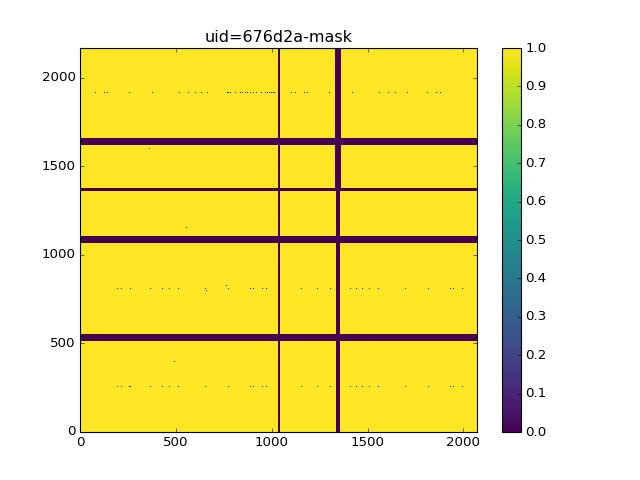

In [24]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid=%s-mask'%uid )
mask = np.array( mask, dtype = np.int32)

# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [25]:
md['mask'] = mask
md['mask_file']= mask_path + mask_name 
md['NOTEBOOK_FULL_PATH'] = NOTEBOOK_FULL_PATH
#psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters
#md = pload_obj(data_dir + 'uid=%s-md'%uid  )

In [26]:
imgsa = apply_mask( imgs, mask )

In [27]:
#show_img( imgsa[0],  vmin= .01, vmax=50, logs= True, image_name= 'uid= %s'%uid) 

<IPython.core.display.Javascript object>


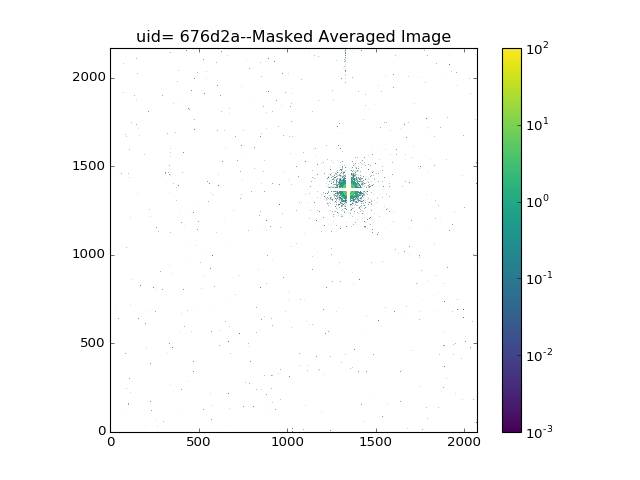

In [29]:
avg_img =  get_avg_img( imgsa, sampling = int(Nimg/3), plot_ = True, uid =uid)

## Determine Compress Or Not

In [30]:
photon_occ = len( np.where(avg_img)[0] ) / ( imgsa[0].size)
compress =  photon_occ < 1.0  #if the photon ocupation < 0.5, do compress

print ("The non-zeros photon occupation is %s."%( photon_occ))
print("Will " + ['NOT', 'DO'][compress]  + " apply compress process.")

The non-zeros photon occupation is 0.004679770559267359.
Will DO apply compress process.


## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [31]:
good_start = 0  #make the good_start at least 0

Averaging images:   1%|          | 136/20000 [00:00<00:14, 1346.87it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_676d2a7f-f584-49f0-80e6-2aa867c96408.cmp.


Get each frame intensity: 100%|██████████| 20000/20000 [00:04<00:00, 4529.03it/s]


No bad frames are involved.
The good_start frame number is: 0 


<IPython.core.display.Javascript object>


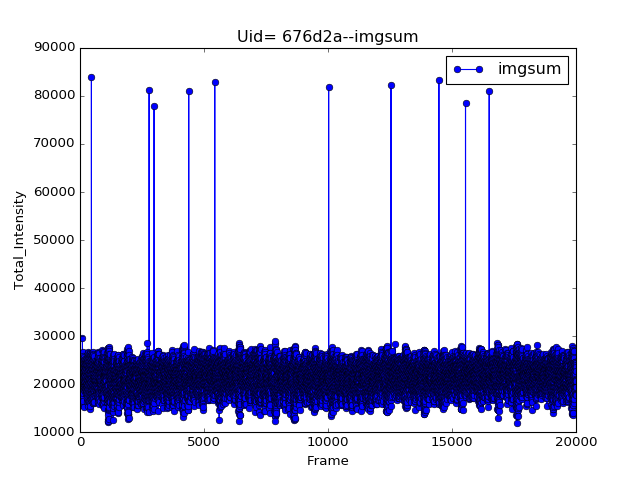

In [32]:
if True:

    if compress:
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1]
        mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                                    force_compress= False, bad_pixel_threshold= 1e14,nobytes=4)    

        min_inten = 0   
        good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
        print ('The good_start frame number is: %s '%good_start)

        FD = Multifile(filename, good_start, len(imgs))
        
        #FD = Multifile(filename, 10,100)

        plot1D( y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])],
               title ='Uid= %s--imgsum'%uid, xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )

In [29]:
#%system ls -lh {sud[2][0]+"*"}|tail -2 ; ls -lh {filename}

In [33]:
bad_pixel_threshold= 3e4#1e14  #if re-define a bad pixel threshold
bad_pixel_low_threshold= 0  #if re-define a bad pixel low threshold

In [34]:
if bad_pixel_threshold<1e14:
    mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                    force_compress=False, bad_pixel_threshold= bad_pixel_threshold,
                bad_pixel_low_threshold=bad_pixel_low_threshold, nobytes=4)
    min_inten = 10
    good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )   
    
    print ('The good_start frame number is: %s '%good_start)


Averaging images:   1%|          | 162/20000 [00:00<00:12, 1619.07it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_676d2a7f-f584-49f0-80e6-2aa867c96408.cmp.


Get each frame intensity: 100%|██████████| 20000/20000 [00:04<00:00, 4404.63it/s]

Bad frame list length is: 10
The good_start frame number is: 0 


## Define a good time series by defining a good start and good end

In [35]:
if False:
        good_start = 0  #0
        good_end =     len(imgs)
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1] 
        FD = Multifile(filename, good_start, good_end)
        avg_img= get_avg_imgc( FD,  beg= None,end=None, plot_=False )
        imgsum,bad_frame_list = get_each_frame_intensityc( FD,  bad_pixel_threshold= 1e14, plot_=False )                           


In [36]:
if not compress:   
    #sampling = 1   #sampling should be one
    sampling = 200  #sampling should be one    
    
    good_start = check_shutter_open( imgsa,  min_inten=5, time_edge = [0,10], plot_ = False )
    print ('The good_start frame number is: %s '%good_start)
    good_series = apply_mask( imgsa[good_start:], mask )
    avg_img =  get_avg_img( good_series, sampling = sampling, plot_ = False, uid =uid)
    imgsum, bad_frame_list = get_each_frame_intensity(good_series ,sampling = sampling, 
                                bad_pixel_threshold= 1e14,   plot_ = False, uid=uid)
    
    

In [37]:
#print ('The bad frame list is: %s'% bad_frame_list)
print ('The number of bad frames is : %s '%len(bad_frame_list))
print ('The good_start frame number is: %s '%good_start)
md['good_start'] = good_start
md['bad_frame_list'] = bad_frame_list

The number of bad frames is : 10 
The good_start frame number is: 0 


In [38]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'], filename='uid=%s-imgsum'%uid, path= data_dir  )
                            

<IPython.core.display.Javascript object>


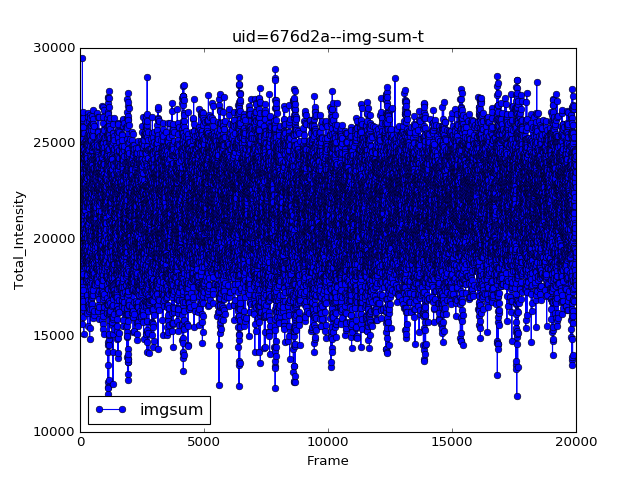

In [39]:
plot1D( y = imgsum_y, title ='uid=%s--img-sum-t'%uid, xlabel='Frame',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

## Plot intensity average image

<IPython.core.display.Javascript object>


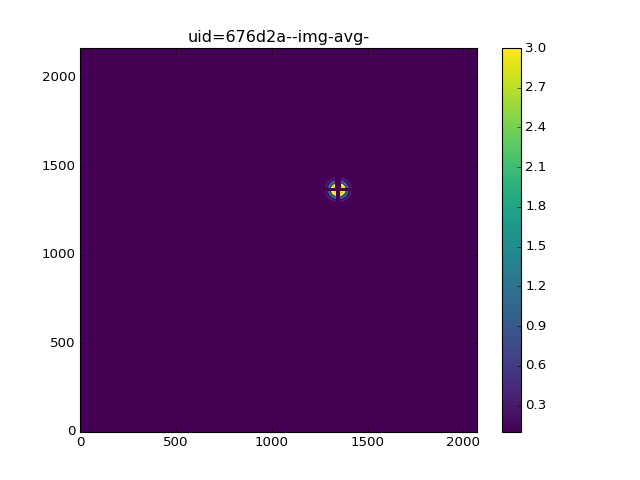

In [40]:
#avg_img = get_avg_imgc( FD,  beg=0,end=10000,sampling = 1, plot_ = False )
show_img( avg_img,  vmin=.1, vmax=3.0, logs=False, image_name= 'uid=%s--img-avg-'%uid,
        save=True, path=data_dir) 
md['avg_img'] = avg_img

## Get circular average 
* Do plot and save q~iq


In [41]:
hmask = create_hot_pixel_mask( avg_img, 2**15 )
mask = mask * hmask

<IPython.core.display.Javascript object>


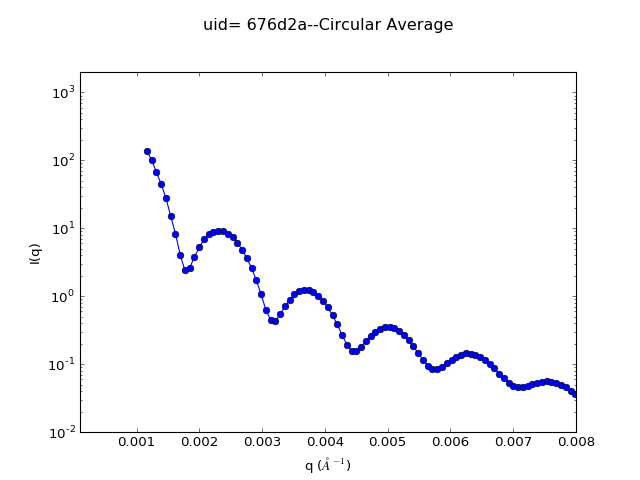

In [42]:
hmask = create_hot_pixel_mask( avg_img, 1e8)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs, nx=None,
                    plot_ = True, show_pixel= False, xlim=[0.0001,.008], ylim = [0.01, 2000], save=True)



# Fit Form Facotr

In [43]:
fit_form = False

In [44]:
if fit_form:
    form_res = fit_form_factor( q,iq,  guess_values={'radius': 2400, 'sigma':0.07, 
         'delta_rho':1E-9 },  fit_range=[0.0001, 0.01], fit_variables={'radius': True, 'sigma':True, 
         'delta_rho':True},  res_pargs=setup_pargs, xlim=[0.0001, 0.015])
    

## Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [45]:
uniform = False

### Define a non-uniform distributed rings by giving edges

In [125]:
if not uniform:
    #width = 4  # in pixel
    width = 0.0002    
    number_rings=1
    #centers = [ 31, 50, 67, 84, 102, 119] #in pixel
    #centers = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
    centers = [ 0.00235,0.00379,0.00508,0.00636,0.00759,0.00889] #in A-1 
    edges = get_non_uniform_edges(  centers, width, number_rings )
    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [126]:
if uniform:
    
    inner_radius= 0.00205  #16
    outer_radius = 0.00932  #112
    width =  0.0002  #2
    num_rings = 14
    edges = None

In [127]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                      unit='A',       pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 



In [128]:
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]


psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters

<IPython.core.display.Javascript object>


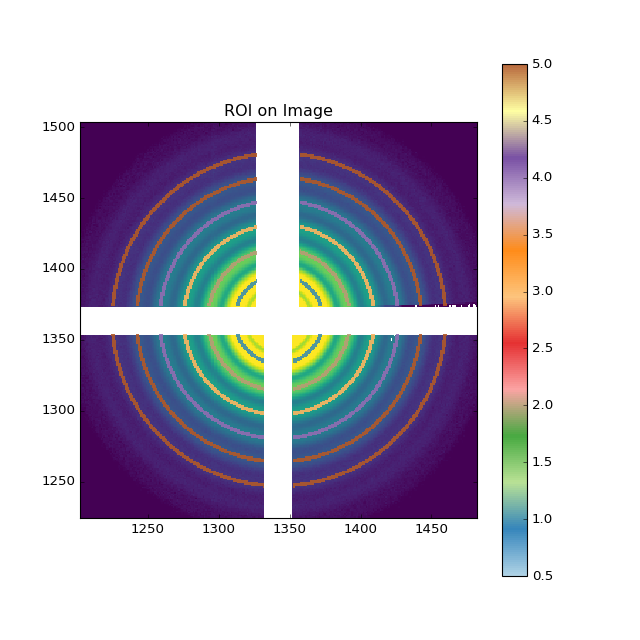

In [129]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=140, alpha=.9,
                 save=True, path=data_dir, uid=uid)

<IPython.core.display.Javascript object>


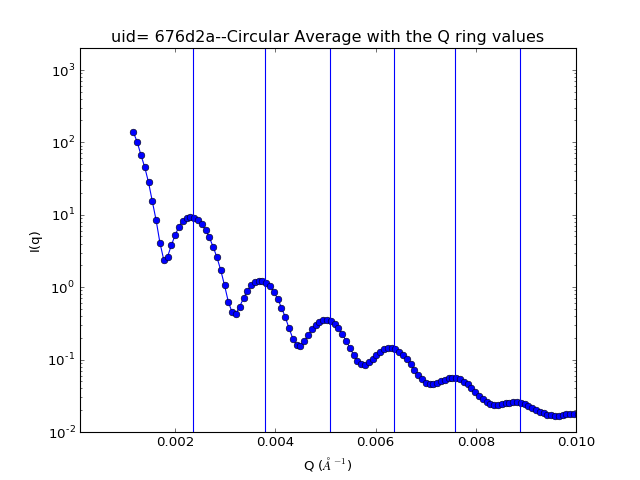

In [130]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.0001,.01],
                  ylim = [0.01, 2000],        save=True, path=data_dir)

## Check one ring intensity

<IPython.core.display.Javascript object>


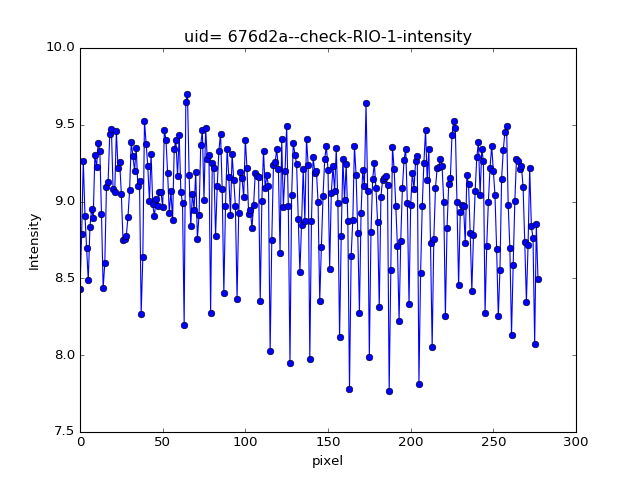

In [131]:
roi_inten = check_ROI_intensity( avg_img, ring_mask, ring_number= 1, uid =uid, save=True, path=data_dir )

## Make angular slices

# Define Qs along a given 'slice'

In [158]:

inner_angle= -180
outer_angle = 180
num_angles =   72

widtha = (outer_angle - inner_angle )/(num_angles+0.01)

ang_mask, ang_center, ang_edges = get_angular_mask( mask,  inner_angle= inner_angle, 
                     outer_angle = outer_angle, width = widtha,  num_angles = num_angles, center = center    )

<IPython.core.display.Javascript object>


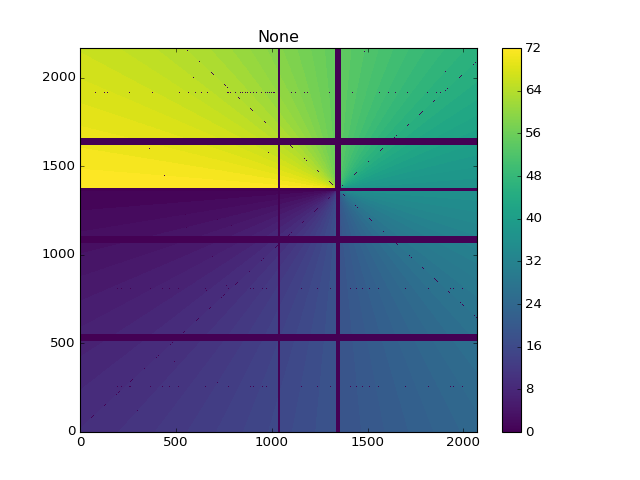

In [159]:
show_img( ang_mask )

* if define one q

<IPython.core.display.Javascript object>


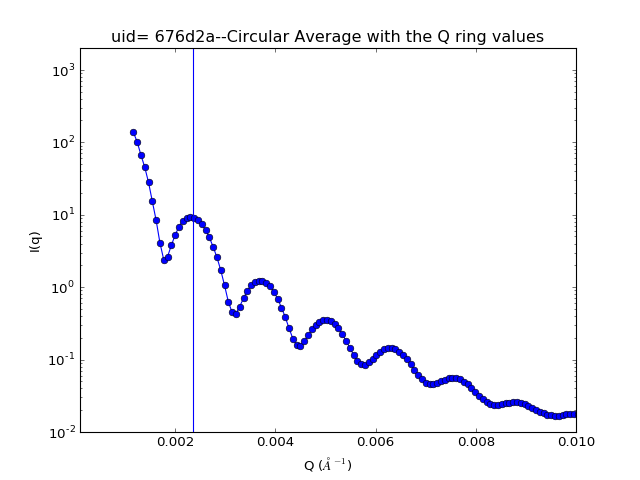

In [160]:
if True:
    width = 0.0002    
    number_rings= 1    
    centers = [ 0.00235 ] #in A-1 
    
    edges = get_non_uniform_edges(  centers, width, number_rings )
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None
    
    ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask,inner_radius=inner_radius,
                    unit='A',outer_radius = outer_radius, 
                    width = width, num_rings = num_rings, edges=edges, pargs=setup_pargs   )
    qind, pixelist = roi.extract_label_indices(  ring_mask  ) 
    
    plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid,
                  ylim = [0.01, 2000] ,xlim=[0.0001,.0100], save=True, path=data_dir)

In [161]:
seg_mask,  rcen, acen = get_ring_anglar_mask( ring_mask, ang_mask, q_ring_center, ang_center)

<IPython.core.display.Javascript object>


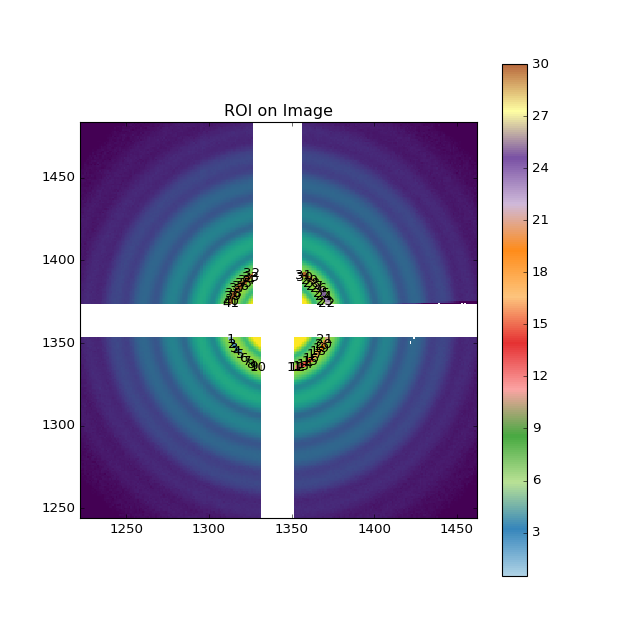

In [162]:
show_ROI_on_image( avg_img, seg_mask, center, label_on = True, rwidth=120, alpha=.9, 
                  vmax=30, save=True, path=data_dir, uid=uid)

# Run time correlation 

### if define another good_series

In [170]:
para_cal =  True  #False #True   #if True to use the parallel calculation


In [171]:
norm = get_pixelist_interp_iq( qp, iq, ring_mask, center)
norm=None

In [172]:
qind, pixelist = roi.extract_label_indices(  seg_mask  ) 
noqs = len(np.unique(qind))
nopr = np.bincount(qind, minlength=(noqs+1))[1:]
nopr

array([8, 8, 6, 8, 6, 6, 8, 6, 8, 8, 3, 8, 8, 6, 8, 6, 6, 8, 6, 8, 8, 3, 8,
       8, 6, 8, 6, 6, 8, 6, 4, 1, 6, 8, 6, 6, 8, 6, 8, 8, 3])

In [173]:
t0 = time.time()
if compress:
    if para_cal:
        g2, lag_steps  =cal_g2p( FD,  seg_mask, bad_frame_list,good_start, num_buf = 8, 
                        imgsum= None, norm=norm )
    else:
        g2, lag_steps  =cal_g2c( FD,  seg_mask, bad_frame_list,good_start, num_buf = 8, 
                        imgsum= None, norm=norm )
else:
    bad_image_process = False
    if  len(bad_frame_list):
        bad_image_process = True
    print( bad_image_process  )

    g2, lag_steps  =cal_g2( good_series,  seg_mask, bad_image_process,
                       bad_frame_list,good_start, num_buf = 8 )
run_time(t0)

In this g2 calculation, the buf and lev number are: 8--13--
Bad frame involved and will be precessed!
19990 frames will be processed...


100%|██████████| 41/41 [00:07<00:00,  5.04it/s]


G2 calculation DONE!
Total time: 0.59 min


In [174]:
taus = lag_steps * timeperframe
res_pargs = dict(taus=taus, q_ring_center=q_ring_center, 
                 ang_center= acen,  path=data_dir, uid=uid +'_mq_1a'       )

In [175]:
save_seg_saxs_g2( g2,  res_pargs )

The g2 of uid= 676d2a_mq_1a is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/676d2a/g2-676d2a_mq_1a-20160919-1841-.csv


### Plot the one time correlation functions

<IPython.core.display.Javascript object>


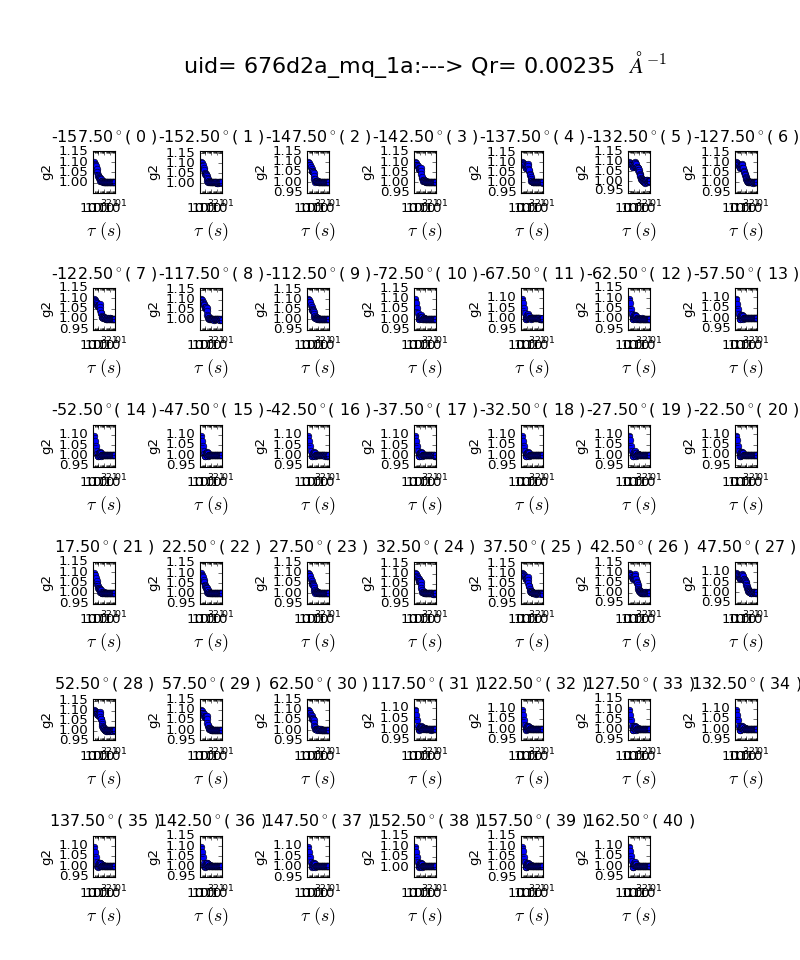

In [176]:
plot_saxs_rad_ang_g2( g2, taus, res_pargs=res_pargs, 
                     master_angle_plot= False, vlim=[0.95, 1.05], )

# Fit g2

In [119]:
fit=True

<IPython.core.display.Javascript object>


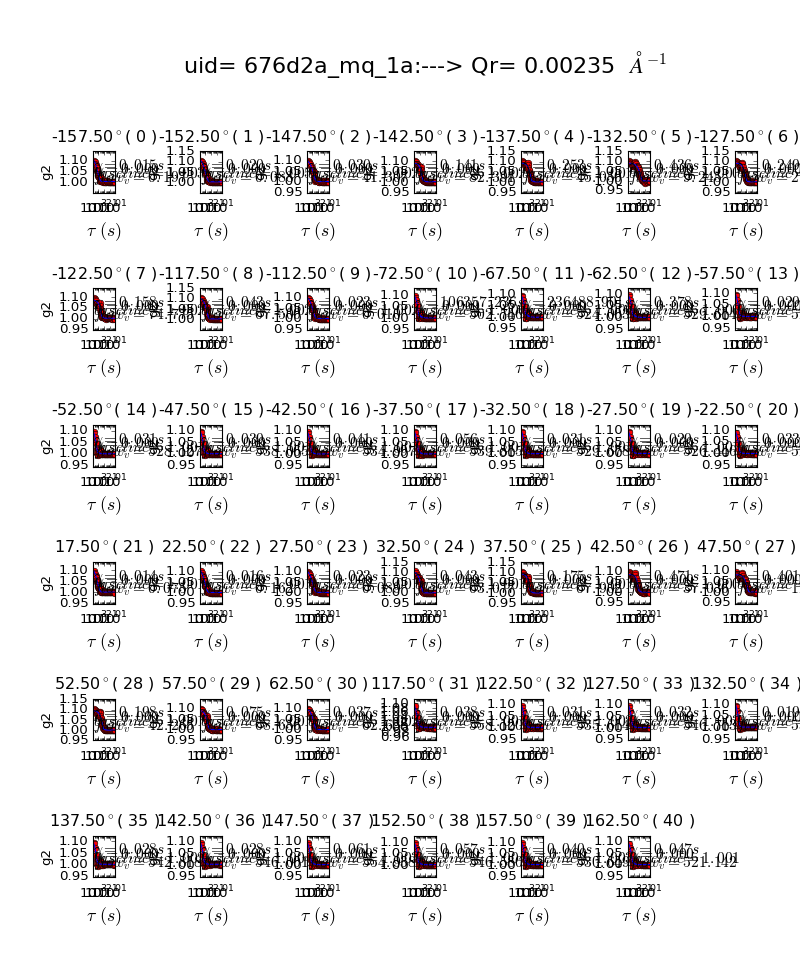

In [120]:
if fit: 
    fit_result = fit_saxs_rad_ang_g2( g2,  res_pargs=res_pargs, master_angle_plot=False,
            function = 'flow_para',  vlim=[0.95, 1.05], 
        fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True,
                      'flow_velocity':True},
        guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,
                     'flow_velocity':1})

In [121]:
psave_obj( fit_result, data_dir + 'uid=%s-g2-fit-para'%uid )

In [177]:
#fit_result['rate']  #in unit of s-1

<IPython.core.display.Javascript object>


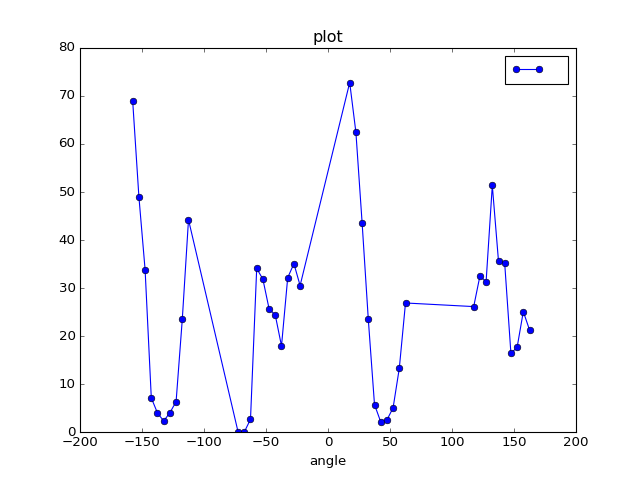

In [178]:
plot1D( x = acen[:], y=fit_result['rate'][:], xlabel='angle')

# get the max angle is 18 and min angle is -72

# For perpendicular

In [224]:
w = 4
inner_angle=  -72 -  w
outer_angle =  -72 + w
num_angles =   1
widtha = (outer_angle - inner_angle )/(num_angles+0.01)
ang_mask, ang_center, ang_edges = get_angular_mask( mask,  inner_angle= inner_angle, 
                     outer_angle = outer_angle, width = widtha,  num_angles = num_angles, center = center    )

In [225]:
inner_radius= 0.002  #16
outer_radius = 0.006  #112
width =  0.0004  #2
num_rings = 10
edges = None   
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask,inner_radius=inner_radius,
                unit='A',outer_radius = outer_radius, 
                width = width, num_rings = num_rings, edges=edges, pargs=setup_pargs   )

seg_mask,  rcen, acen = get_ring_anglar_mask( ring_mask, ang_mask, q_ring_center, ang_center)

In [226]:
t0 = time.time()
g2, lag_steps  =cal_g2p( FD,  seg_mask, bad_frame_list,good_start, num_buf = 8, 
                        imgsum= None, norm=norm )
run_time(t0)

In this g2 calculation, the buf and lev number are: 8--13--
Bad frame involved and will be precessed!
19990 frames will be processed...


100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


G2 calculation DONE!
Total time: 0.30 min


In [227]:
taus = lag_steps * timeperframe
res_pargs = dict(taus=taus, q_ring_center=q_ring_center, 
                 ang_center= [acen[0]],  path=data_dir, uid=uid +'_mq_perp'       )
save_seg_saxs_g2( g2,  res_pargs )

The g2 of uid= 676d2a_mq_perp is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/676d2a/g2-676d2a_mq_perp-20160919-1859-.csv


<IPython.core.display.Javascript object>


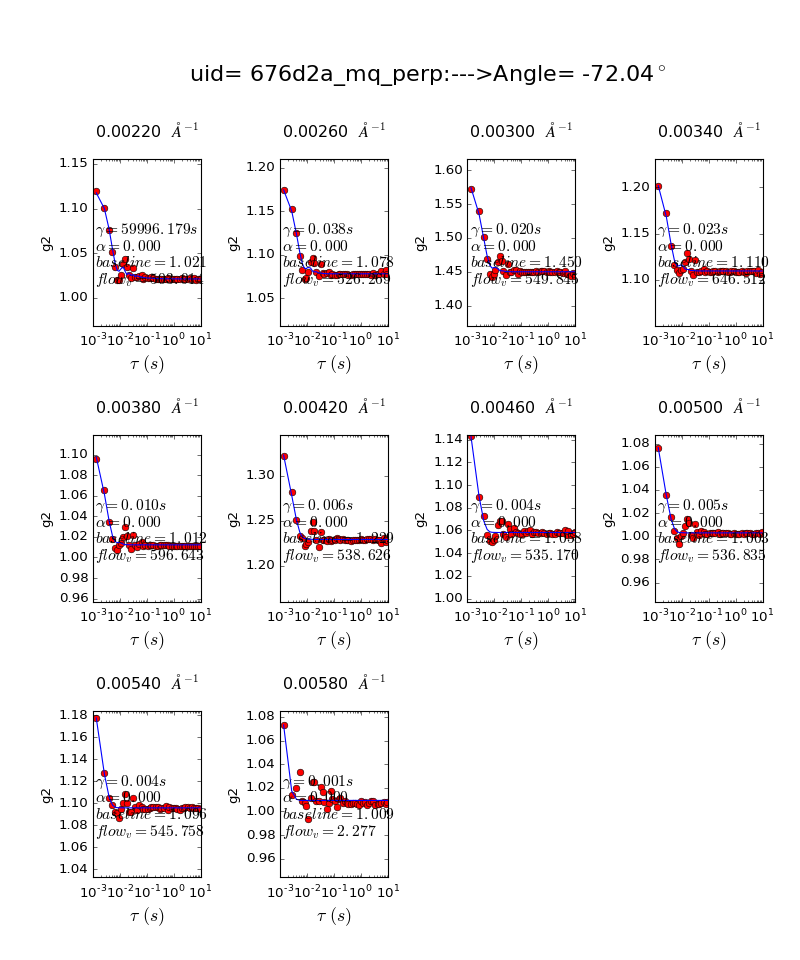

In [228]:
#plot_saxs_rad_ang_g2( g2, taus, res_pargs=res_pargs,  master_angle_plot= True, vlim=[0.95, 1.05], )
fit_result = fit_saxs_rad_ang_g2( g2,  res_pargs=res_pargs, master_angle_plot= True,
        function = 'flow_para',  vlim=[0.95, 1.05], 
    fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True,
                  'flow_velocity':True},
    guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,
                 'flow_velocity':1})

# For parallel

In [210]:
w = 4
inner_angle=  18 - w
outer_angle =  18 +w
num_angles =   1
widtha = (outer_angle - inner_angle )/(num_angles+0.01)
ang_mask, ang_center, ang_edges = get_angular_mask( mask,  inner_angle= inner_angle, 
                     outer_angle = outer_angle, width = widtha,  num_angles = num_angles, center = center    )

In [220]:

inner_radius= 0.002  #16
outer_radius = 0.006  #112
width =  0.0004  #2
num_rings = 10
edges = None   
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask,inner_radius=inner_radius,
                unit='A',outer_radius = outer_radius, 
                width = width, num_rings = num_rings, edges=edges, pargs=setup_pargs   )

seg_mask,  rcen, acen = get_ring_anglar_mask( ring_mask, ang_mask, q_ring_center, ang_center)

In [221]:
t0 = time.time()
g2, lag_steps  =cal_g2p( FD,  seg_mask, bad_frame_list,good_start, num_buf = 8, 
                        imgsum= None, norm=norm )
run_time(t0)

In this g2 calculation, the buf and lev number are: 8--13--
Bad frame involved and will be precessed!
19990 frames will be processed...


100%|██████████| 10/10 [00:02<00:00,  5.27it/s]


G2 calculation DONE!
Total time: 0.45 min


In [222]:
taus = lag_steps * timeperframe
res_pargs = dict(taus=taus, q_ring_center=q_ring_center, 
                 ang_center= [acen[0]],  path=data_dir, uid=uid +'_mq_para'       )
save_seg_saxs_g2( g2,  res_pargs )

The g2 of uid= 676d2a_mq_para is saved with filename as /XF11ID/analysis/2016_2/yuzhang/Results/676d2a/g2-676d2a_mq_para-20160919-1859-.csv


<IPython.core.display.Javascript object>


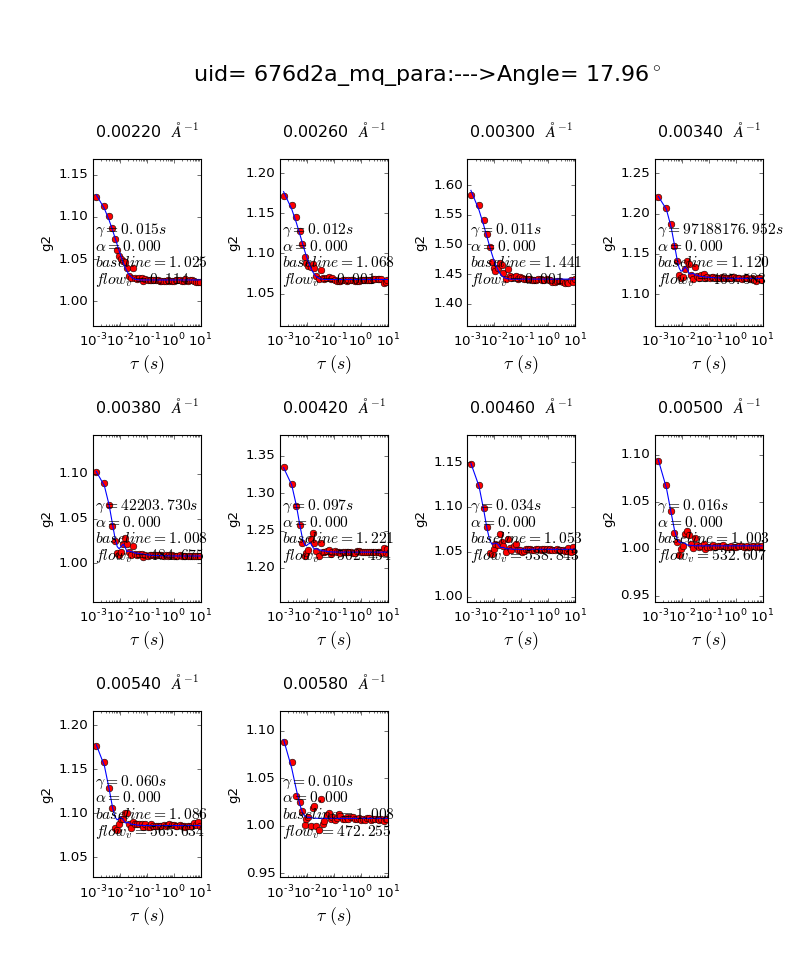

In [223]:
#plot_saxs_rad_ang_g2( g2, taus, res_pargs=res_pargs,  master_angle_plot= True, vlim=[0.95, 1.05], )
fit_result = fit_saxs_rad_ang_g2( g2,  res_pargs=res_pargs, master_angle_plot= True,
        function = 'flow_para',  vlim=[0.95, 1.05], 
    fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True,
                  'flow_velocity':True},
    guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,
                 'flow_velocity':1})